In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.preprocessing import Imputer
from sklearn.model_selection import  cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier

from skll.metrics import spearman

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

import warnings

In [2]:
# setting up the styling for the plots in this notebook
sns.set(style="white", palette="colorblind", font_scale=1.2, 
        rc={"figure.figsize":(12,9)})
RANDOM_STATE = 420
N_JOBS=8


In [3]:
data = pd.read_csv("Open_Univ_Data_Final_merged.csv")

In [4]:
data.drop(columns=['date_unregistration', 'Exam_score','TMA_score','CMA_score','mean_score','registration_before','unique' ], inplace=True)
data = data.replace(to_replace='55<=', value = '55')
data.head()

,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,...,quiz,repeatactivity,resource,sharedsubpage,subpage,url,sum_click,days_interacted,daily_click,final_result
0,11391,AAA,2013J,M,East Anglian Region,HE Qualification,10.0,55,0,240,...,0.0,0.0,13.0,0.0,32.0,5.0,934,40,23.350000,Pass
1,28400,AAA,2013J,F,Scotland,HE Qualification,3.0,35-55,0,60,...,0.0,0.0,12.0,0.0,87.0,48.0,1435,80,17.937500,Pass
2,31604,AAA,2013J,F,South East Region,A Level or Equivalent,6.0,35-55,0,60,...,0.0,0.0,19.0,0.0,144.0,90.0,2158,123,17.544715,Pass
3,32885,AAA,2013J,F,West Midlands Region,Lower Than A Level,6.0,0-35,0,60,...,0.0,0.0,45.0,0.0,79.0,14.0,1034,70,14.771429,Pass
4,38053,AAA,2013J,M,Wales,A Level or Equivalent,9.0,35-55,0,60,...,0.0,0.0,11.0,0.0,91.0,45.0,2445,143,17.097902,Pass


In [5]:
data = data.dropna()
data = data.replace(to_replace ="Distinction", value ="Pass")
data = data.replace(to_replace ="Withdrawn", value ="Fail")
data.drop(columns=['repeatactivity','sharedsubpage','url'], inplace=True)
data.drop(columns=['dualpane','glossary','date_registration_pos'], inplace=True)
data.drop(columns=['ouelluminate','subpage','questionnaire'], inplace=True)
data.drop(columns=['htmlactivity','externalquiz','folder','num_of_prev_attempts', 'forumng'], inplace=True)

In [6]:
data.head()

,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,studied_credits,disability,...,oucollaborate,oucontent,ouwiki,page,quiz,resource,sum_click,days_interacted,daily_click,final_result
0,11391,AAA,2013J,M,East Anglian Region,HE Qualification,10.0,55,240,N,...,0.0,553.0,0.0,0.0,0.0,13.0,934,40,23.350000,Pass
1,28400,AAA,2013J,F,Scotland,HE Qualification,3.0,35-55,60,N,...,0.0,537.0,0.0,0.0,0.0,12.0,1435,80,17.937500,Pass
2,31604,AAA,2013J,F,South East Region,A Level or Equivalent,6.0,35-55,60,N,...,0.0,836.0,0.0,0.0,0.0,19.0,2158,123,17.544715,Pass
3,32885,AAA,2013J,F,West Midlands Region,Lower Than A Level,6.0,0-35,60,N,...,0.0,494.0,0.0,0.0,0.0,45.0,1034,70,14.771429,Pass
4,38053,AAA,2013J,M,Wales,A Level or Equivalent,9.0,35-55,60,N,...,0.0,900.0,0.0,0.0,0.0,11.0,2445,143,17.097902,Pass


In [7]:
train_cols = data.columns[0:-1]
label = data.columns[-1]
X = data[train_cols]
y = data[label].apply(lambda x: 1 if x == "Pass" else 0)
X.head(20)

,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,studied_credits,disability,...,homepage,oucollaborate,oucontent,ouwiki,page,quiz,resource,sum_click,days_interacted,daily_click
0,11391,AAA,2013J,M,East Anglian Region,HE Qualification,10.0,55,240,N,...,138.0,0.0,553.0,0.0,0.0,0.0,13.0,934,40,23.350000
1,28400,AAA,2013J,F,Scotland,HE Qualification,3.0,35-55,60,N,...,324.0,0.0,537.0,0.0,0.0,0.0,12.0,1435,80,17.937500
2,31604,AAA,2013J,F,South East Region,A Level or Equivalent,6.0,35-55,60,N,...,432.0,0.0,836.0,0.0,0.0,0.0,19.0,2158,123,17.544715
3,32885,AAA,2013J,F,West Midlands Region,Lower Than A Level,6.0,0-35,60,N,...,204.0,0.0,494.0,0.0,0.0,0.0,45.0,1034,70,14.771429
4,38053,AAA,2013J,M,Wales,A Level or Equivalent,9.0,35-55,60,N,...,512.0,0.0,900.0,0.0,0.0,0.0,11.0,2445,143,17.097902
5,45462,AAA,2013J,M,Scotland,HE Qualification,4.0,0-35,60,N,...,320.0,2.0,915.0,0.0,0.0,0.0,8.0,1492,90,16.577778
6,45642,AAA,2013J,F,North Western Region,A Level or Equivalent,10.0,0-35,120,N,...,295.0,1.0,508.0,0.0,0.0,0.0,16.0,1428,105,13.600000
7,52130,AAA,2013J,F,East Anglian Region,A Level or Equivalent,8.0,0-35,90,N,...,476.0,2.0,714.0,0.0,0.0,0.0,19.0,1894,122,15.524590
9,57506,AAA,2013J,M,South Region,Lower Than A Level,8.0,35-55,60,N,...,360.0,0.0,708.0,0.0,0.0,0.0,16.0,1319,90,14.655556
10,58873,AAA,2013J,F,East Anglian Region,A Level or Equivalent,3.0,0-35,60,N,...,488.0,2.0,811.0,0.0,0.0,0.0,6.0,1732,120,14.433333


In [8]:
seed = 1
X_enc = pd.get_dummies(X, prefix_sep='.')

In [9]:
a = list(X_enc['id_student'])
X_enc.drop(columns=['id_student'], inplace=True)
X_enc.head()

,imd_band,studied_credits,date_registration,dataplus,homepage,oucollaborate,oucontent,ouwiki,page,quiz,...,highest_education.A Level or Equivalent,highest_education.HE Qualification,highest_education.Lower Than A Level,highest_education.No Formal quals,highest_education.Post Graduate Qualification,age_band.0-35,age_band.35-55,age_band.55,disability.N,disability.Y
0,10.0,240,-159.0,0.0,138.0,0.0,553.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,1,1,0
1,3.0,60,-53.0,10.0,324.0,0.0,537.0,0.0,0.0,0.0,...,0,1,0,0,0,0,1,0,1,0
2,6.0,60,-52.0,2.0,432.0,0.0,836.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,0,1,0
3,6.0,60,-176.0,0.0,204.0,0.0,494.0,0.0,0.0,0.0,...,0,0,1,0,0,1,0,0,1,0
4,9.0,60,-110.0,7.0,512.0,0.0,900.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,0,1,0


In [10]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_enc)
X_std = sc.transform(X_enc)
X_a = pd.DataFrame(X_std, index=X_enc.index, columns=X_enc.columns)
X_a['id'] = a
X_a.head()

/home/deepti/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/deepti/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


,imd_band,studied_credits,date_registration,dataplus,homepage,oucollaborate,oucontent,ouwiki,page,quiz,...,highest_education.HE Qualification,highest_education.Lower Than A Level,highest_education.No Formal quals,highest_education.Post Graduate Qualification,age_band.0-35,age_band.35-55,age_band.55,disability.N,disability.Y,id
0,1.656674,4.259757,-1.940195,-0.241680,-0.378892,-0.355516,0.190255,-0.365531,-0.392564,-0.550658,...,2.379648,-0.786574,-0.092649,-0.081603,-1.520018,-0.646954,11.894653,0.3261,-0.3261,11391
1,-0.831800,-0.437116,0.291122,1.115975,0.188713,-0.355516,0.166591,-0.365531,-0.392564,-0.550658,...,2.379648,-0.786574,-0.092649,-0.081603,-1.520018,1.545704,-0.084071,0.3261,-0.3261,28400
2,0.234689,-0.437116,0.312172,0.029851,0.518291,-0.355516,0.608814,-0.365531,-0.392564,-0.550658,...,-0.420230,-0.786574,-0.092649,-0.081603,-1.520018,1.545704,-0.084071,0.3261,-0.3261,31604
3,0.234689,-0.437116,-2.298048,-0.241680,-0.177484,-0.355516,0.102993,-0.365531,-0.392564,-0.550658,...,-0.420230,1.271335,-0.092649,-0.081603,0.657887,-0.646954,-0.084071,0.3261,-0.3261,32885
4,1.301178,-0.437116,-0.908737,0.708678,0.762422,-0.355516,0.703471,-0.365531,-0.392564,-0.550658,...,-0.420230,-0.786574,-0.092649,-0.081603,-1.520018,1.545704,-0.084071,0.3261,-0.3261,38053


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_a, y, test_size=0.25, random_state=seed)

In [12]:
X_train

,imd_band,studied_credits,date_registration,dataplus,homepage,oucollaborate,oucontent,ouwiki,page,quiz,...,highest_education.HE Qualification,highest_education.Lower Than A Level,highest_education.No Formal quals,highest_education.Post Graduate Qualification,age_band.0-35,age_band.35-55,age_band.55,disability.N,disability.Y,id
3694,-0.120807,2.694133,0.943677,-0.241680,-0.015747,-0.355516,-0.612847,-0.365531,-0.392564,-0.391515,...,-0.420230,-0.786574,-0.092649,-0.081603,0.657887,-0.646954,-0.084071,0.326100,-0.326100,2284583
22363,-1.187296,-0.437116,-0.656136,1.523271,0.573220,-0.355516,1.812727,-0.170936,0.625368,0.986325,...,-0.420230,1.271335,-0.092649,-0.081603,-1.520018,1.545704,-0.084071,0.326100,-0.326100,594229
9996,-1.187296,-0.437116,-1.392891,-0.241680,0.329089,-0.178234,-0.278591,-0.365531,-0.392564,0.353943,...,-0.420230,1.271335,-0.092649,-0.081603,-1.520018,1.545704,-0.084071,0.326100,-0.326100,1612600
1551,0.234689,-0.437116,0.375322,-0.241680,-0.208000,-0.355516,-0.624679,-0.365531,-0.392564,-0.393609,...,-0.420230,1.271335,-0.092649,-0.081603,0.657887,-0.646954,-0.084071,-3.066544,3.066544,545697
2927,1.656674,-0.437116,0.754225,-0.241680,-0.565042,-0.089592,-0.615805,-0.365531,-0.392564,-0.473180,...,-0.420230,1.271335,-0.092649,-0.081603,0.657887,-0.646954,-0.084071,0.326100,-0.326100,576983
4002,-0.476304,1.128508,-4.571466,-0.241680,-0.763399,-0.355516,-0.617284,-0.365531,-0.392564,-0.492026,...,-0.420230,1.271335,-0.092649,-0.081603,0.657887,-0.646954,-0.084071,0.326100,-0.326100,475981
20800,-0.120807,1.128508,1.048928,-0.241680,-0.760347,-0.266875,-0.627637,-0.365531,-0.392564,-0.548564,...,-0.420230,-0.786574,-0.092649,-0.081603,0.657887,-0.646954,-0.084071,0.326100,-0.326100,395814
18821,0.590185,0.345696,-1.308691,-0.241680,-0.259878,-0.266875,-0.324440,-0.333099,0.116402,0.393728,...,-0.420230,1.271335,-0.092649,-0.081603,0.657887,-0.646954,-0.084071,0.326100,-0.326100,118050
15704,-1.187296,-0.437116,0.733175,-0.241680,-0.342272,-0.355516,0.218356,-0.354720,-0.392564,-0.372669,...,-0.420230,-0.786574,-0.092649,-0.081603,-1.520018,1.545704,-0.084071,-3.066544,3.066544,597573
23566,0.234689,0.084758,-0.235132,-0.241680,-0.290394,-0.355516,-0.058219,-0.354720,-0.053253,0.527743,...,-0.420230,-0.786574,-0.092649,-0.081603,0.657887,-0.646954,-0.084071,0.326100,-0.326100,1998834


In [13]:
features = list(X_train.columns)
features.remove('id')
features

['imd_band',
 'studied_credits',
 'date_registration',
 'dataplus',
 'homepage',
 'oucollaborate',
 'oucontent',
 'ouwiki',
 'page',
 'quiz',
 'resource',
 'sum_click',
 'days_interacted',
 'daily_click',
 'code_module.AAA',
 'code_module.BBB',
 'code_module.CCC',
 'code_module.DDD',
 'code_module.EEE',
 'code_module.FFF',
 'code_module.GGG',
 'code_presentation.2013B',
 'code_presentation.2013J',
 'code_presentation.2014B',
 'code_presentation.2014J',
 'gender.F',
 'gender.M',
 'region.East Anglian Region',
 'region.East Midlands Region',
 'region.Ireland',
 'region.London Region',
 'region.North Region',
 'region.North Western Region',
 'region.Scotland',
 'region.South East Region',
 'region.South Region',
 'region.South West Region',
 'region.Wales',
 'region.West Midlands Region',
 'region.Yorkshire Region',
 'highest_education.A Level or Equivalent',
 'highest_education.HE Qualification',
 'highest_education.Lower Than A Level',
 'highest_education.No Formal quals',
 'highest_edu

In [14]:
train = X_train[features]
y_train

3694     1
22363    1
9996     0
1551     1
2927     0
4002     1
20800    0
18821    1
15704    1
23566    1
21946    1
25525    1
21596    1
13144    0
23341    1
20031    0
6451     0
2123     1
19130    0
5743     1
3833     1
4380     1
23148    0
7711     0
21212    1
17386    1
8393     0
8334     1
7276     0
6263     1
        ..
19028    1
12128    1
17824    0
20252    1
25535    1
17619    0
23921    0
25477    1
4826     1
20791    0
8633     0
19686    0
3012     1
13083    0
22700    1
22722    1
3515     0
11345    1
7892     0
16961    1
21482    1
152      0
22368    0
20087    0
7965     0
11310    1
17984    1
5257     1
12591    0
246      1
Name: final_result, Length: 18594, dtype: int64

In [15]:
pipe = Pipeline([("imputer", Imputer()),
                 ("estimator", RandomForestClassifier(random_state=RANDOM_STATE))])
spearman_scorer = make_scorer(spearman)
rf_param_space = {
    'imputer__strategy': Categorical(['mean', 'median', 'most_frequent']),
    'estimator__max_features': Integer(1, 8),
    'estimator__n_estimators': Integer(50, 500), 
    'estimator__min_samples_split': Integer(2, 200),
}

search = BayesSearchCV(pipe, 
                      rf_param_space, 
                      cv=10,
                      n_jobs=N_JOBS, 
                      verbose=0, 
                      error_score=-9999, 
                      scoring=spearman_scorer, 
                      random_state=RANDOM_STATE,
                      return_train_score=True, 
                      n_iter=3)


/home/deepti/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [16]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    search.fit(train, y_train) 
search.best_params_

{'estimator__max_features': 7,
 'estimator__min_samples_split': 93,
 'estimator__n_estimators': 137,
 'imputer__strategy': 'mean'}

In [17]:
test = X_test[features]

predicted = search.predict(test)
model_test_score = spearman_scorer(search, test, y_test)
model_test_score

0.6638873752065545

In [18]:
estimator = search.best_estimator_.named_steps['estimator']
imputer = search.best_estimator_.named_steps['imputer']

estimator.feature_importances_


array([0.00677998, 0.01256855, 0.00859704, 0.01399008, 0.13332516,
       0.0168552 , 0.05023262, 0.03249402, 0.02370733, 0.11400123,
       0.06104864, 0.13337239, 0.20914895, 0.02485844, 0.00272611,
       0.02173888, 0.01519444, 0.00701237, 0.00516314, 0.02842876,
       0.0224251 , 0.00306612, 0.00178836, 0.00092245, 0.00351721,
       0.01024917, 0.01013204, 0.00067881, 0.00056676, 0.00071905,
       0.00078692, 0.00061499, 0.00087892, 0.00067481, 0.00062968,
       0.00061601, 0.00058511, 0.00082664, 0.00071989, 0.00056918,
       0.00302491, 0.00071381, 0.00789755, 0.0007866 , 0.00021021,
       0.00100972, 0.00116956, 0.00038472, 0.00128084, 0.00131157])

In [19]:
import eli5

# create our dataframe of feature importances
feat_imp_df = eli5.explain_weights_df(estimator, feature_names=features)
feat_imp_df

,feature,weight,std
0,days_interacted,0.209149,0.167175
1,sum_click,0.133372,0.144641
2,homepage,0.133325,0.153659
3,quiz,0.114001,0.058743
4,resource,0.061049,0.078789
5,oucontent,0.050233,0.046845
6,ouwiki,0.032494,0.027279
7,code_module.FFF,0.028429,0.020161
8,daily_click,0.024858,0.012281
9,page,0.023707,0.015543


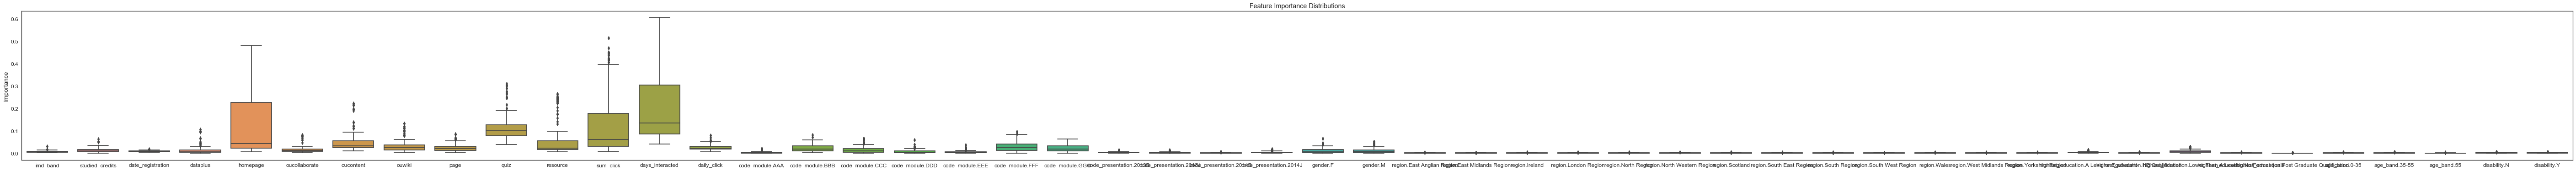

In [20]:
all_feat_imp_df = pd.DataFrame(data=[tree.feature_importances_ for tree in 
                                     estimator],
                               columns=features)
plt.figure(figsize=(100, 6))
(sns.boxplot(data=all_feat_imp_df)
        .set(title='Feature Importance Distributions',
             ylabel='Importance'));

In [21]:
from concurrent.futures import ProcessPoolExecutor

def multiproc_iter_func(max_workers, an_iter, func, item_kwarg, **kwargs):
    """
    A helper functions that applies a function to each item in an iterable using
    multiple processes. 'item_kwarg' is the keyword argument for the item in the
    iterable that we pass to the function.
    """
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        future_results = [executor.submit(func, **{item_kwarg: item}, **kwargs)
                          for item in an_iter]

        results = [future.result() for future in future_results]
        
    return results

In [22]:
train_X_imp = imputer.transform(train.head(480))
train_expl_list = multiproc_iter_func(N_JOBS, train_X_imp, 
                                      eli5.explain_prediction_df, 'doc',
                                      estimator=estimator, 
                                      feature_names=features)
train_expl_df = pd.concat(train_expl_list, keys=(X_train.head(480)).id, 
                          names=['id'])

In [23]:
list(train_expl_df.value)

[1.0,
 -0.023747725433375194,
 -0.01574675110037564,
 -0.12016772611508778,
 -0.391515142391259,
 1.7695511996243523,
 0.1755426236203851,
 -0.786574471567042,
 -0.5619465161924412,
 1.0899448968687453,
 -1.0899448968687453,
 -0.3841422466893464,
 -0.12080737691216867,
 1.099829836133389,
 -0.48219607004071946,
 0.943676741523345,
 -0.3925641607946385,
 -0.41476780954997955,
 -0.36553114065930414,
 1.6202133771913412,
 0.3260999880336496,
 -0.32609998803364965,
 -0.18225052312063567,
 -0.3096383027512889,
 -0.5496370077934477,
 -0.2741441903064843,
 -0.35839626599264296,
 -0.09264915319225633,
 -0.29038715982154445,
 -0.3114340226155098,
 -0.18154051924201772,
 -0.2823063770352408,
 -0.3457316416368344,
 -0.08407139242990794,
 -0.16818744850589554,
 -0.25842099636005705,
 -0.7263205832473691,
 -0.27012600808528686,
 -0.3322716404555382,
 -0.2924237077465274,
 0.6578868586356866,
 -0.42023020148377765,
 -0.64695447630401,
 -0.3043680822365485,
 -0.3555163242738387,
 -0.03814149678301573

In [24]:
# Contributions for test set predictions
# we need to impute the missing values in the test set
test_X_imp = imputer.transform(test.head(480))
# now repeat what we did with the training data on the test data
test_expl_list = multiproc_iter_func(N_JOBS, test_X_imp, 
                                     eli5.explain_prediction_df, 'doc', 
                                     estimator=estimator,
                                     feature_names=features)

test_expl_df = pd.concat(test_expl_list, keys=(X_test.head(480)).id, 
                         names=['id'])
test_expl_df.head(18)

target                  feature    weight     value
id                                                            
593613 0        0                   <BIAS>  0.408656  1.000000
       1        0                     quiz  0.147410 -0.519248
       2        0          days_interacted  0.114177 -0.990285
       3        0                 homepage  0.074486 -0.644385
       4        0                sum_click  0.062779 -0.699033
       5        0                oucontent  0.060219 -0.623200
       6        0                 resource  0.032753 -0.371451
       7        0              daily_click  0.018170 -0.277703
       8        0  code_presentation.2014J  0.014099 -0.726321
       9        0          studied_credits  0.014037  1.128508
       10       0          code_module.GGG  0.009537 -0.304368
       11       0            oucollaborate  0.007557 -0.355516
       12       0  code_presentation.2013J  0.007075  1.620213
       13       0                   ouwiki  0.003950 -0.365531
       14       0        date_registration  0.003127 -0.508784
       15       0                 dataplus  0.002677 -0.241680
       16       0          code_module.AAA  0.001776 -0.168187
       17       0             region.Wales  0.001070 -0.274144

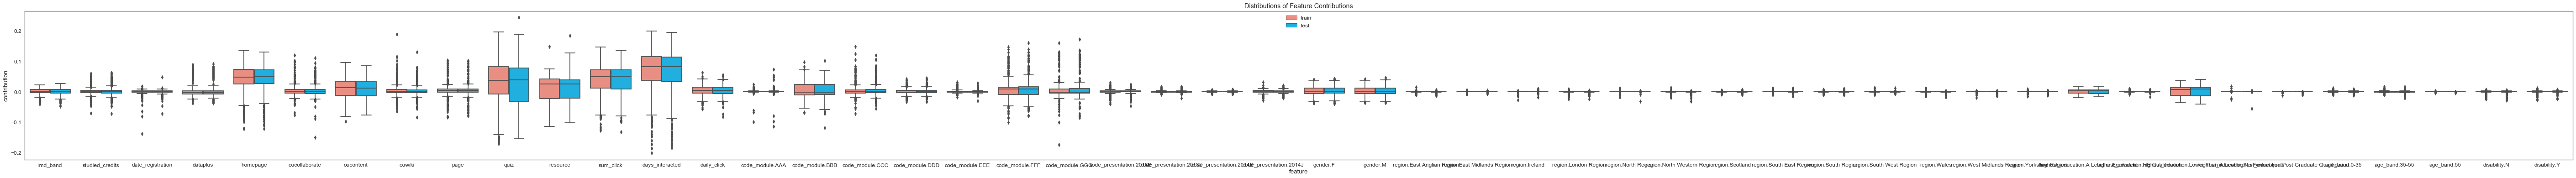

In [25]:
train_expl_df.rename(columns={'weight': 'contribution'}, inplace=True)
test_expl_df.rename(columns={'weight': 'contribution'}, inplace=True)
train_expl_df['data'] = 'train'
test_expl_df['data'] = 'test'
train_test_expl_df = pd.concat([train_expl_df, test_expl_df])
plt.figure(figsize=(100, 6))
sns.boxplot(x='feature', y='contribution', hue='data', order=features,
            data=train_test_expl_df.loc[train_test_expl_df.feature!=''],
            palette={'train': 'salmon', 
                     'test':'deepskyblue'})
plt.legend(loc=9)
plt.title('Distributions of Feature Contributions');

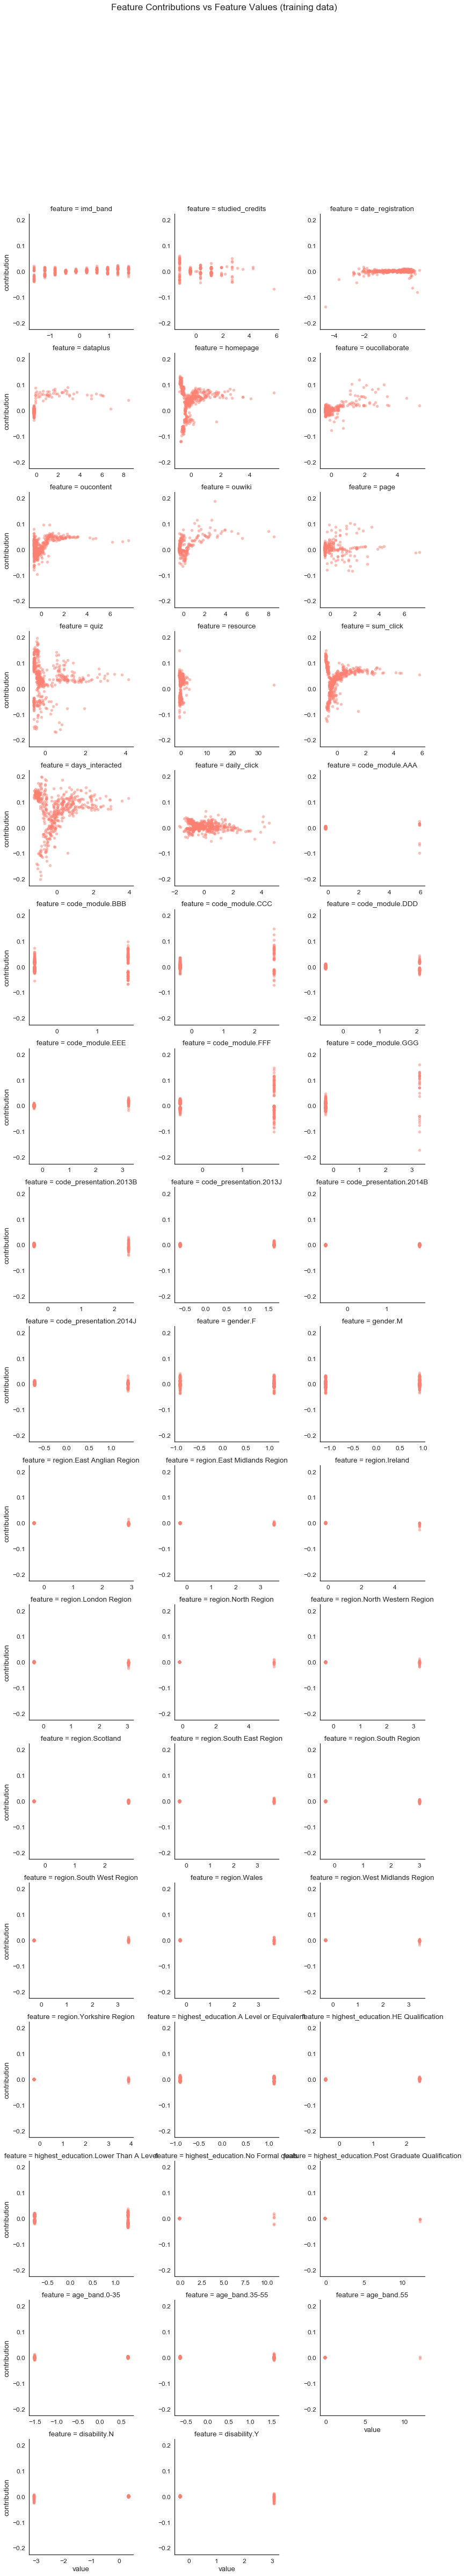

In [26]:
fg = sns.lmplot(x='value', y='contribution', col='feature',
                data=train_expl_df.loc[train_expl_df.feature!=''], 
                col_order=features, sharex=False, col_wrap=3, fit_reg=False,
                size=4, scatter_kws={'color':'salmon', 'alpha': 0.5, 's':30})
fg.fig.suptitle('Feature Contributions vs Feature Values (training data)')
fg.fig.subplots_adjust(top=0.90);

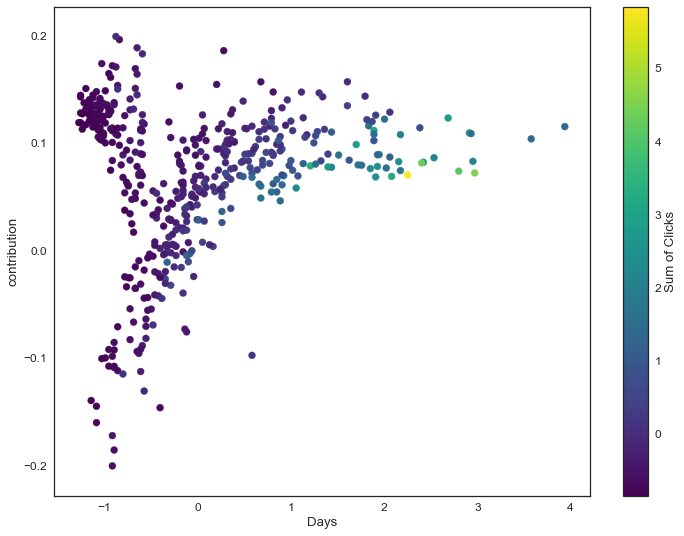

In [27]:
cmap = plt.get_cmap('viridis')
train_contrib_df = (train_expl_df.groupby(['id','feature'])
                                 .contribution
                                 .aggregate('first')
                                 .unstack())
# add in the feature values
train_feat_contrib_df = train_contrib_df.merge((X_train.head(480))[['id'] + features],
                                               how='left', left_index=True, 
                                               right_on='id',
                                               suffixes=('_contrib', '_value'))
# now we can plot
plt.scatter(x='days_interacted_value', y='days_interacted_contrib', c='sum_click_value', cmap=cmap,
            data=train_feat_contrib_df)
plt.xlabel('Days')
plt.ylabel('contribution')
plt.colorbar(label='Sum of Clicks');

In [28]:
import lime
from lime.lime_tabular import LimeTabularExplainer
train_X_imp_df = pd.DataFrame(train_X_imp, columns=features)

In [29]:
explainer = LimeTabularExplainer(train_X_imp_df, mode='classification', 
                                 feature_names=features, 
                                 random_state=RANDOM_STATE, 
                                 discretize_continuous=False) 

In [30]:
test_X_imp_df = pd.DataFrame(test_X_imp, columns=features)
test_X_imp_df.columns

Index(['imd_band', 'studied_credits', 'date_registration', 'dataplus',
       'homepage', 'oucollaborate', 'oucontent', 'ouwiki', 'page', 'quiz',
       'resource', 'sum_click', 'days_interacted', 'daily_click',
       'code_module.AAA', 'code_module.BBB', 'code_module.CCC',
       'code_module.DDD', 'code_module.EEE', 'code_module.FFF',
       'code_module.GGG', 'code_presentation.2013B', 'code_presentation.2013J',
       'code_presentation.2014B', 'code_presentation.2014J', 'gender.F',
       'gender.M', 'region.East Anglian Region', 'region.East Midlands Region',
       'region.Ireland', 'region.London Region', 'region.North Region',
       'region.North Western Region', 'region.Scotland',
       'region.South East Region', 'region.South Region',
       'region.South West Region', 'region.Wales',
       'region.West Midlands Region', 'region.Yorkshire Region',
       'highest_education.A Level or Equivalent',
       'highest_education.HE Qualification',
       'highest_education.Low

In [31]:
test_X_imp_df = pd.DataFrame(test_X_imp, columns=features)
# the number of features to include in our predictions
num_features = len(features)
# the index of the instance we want to explaine
exp_idx = 0
exp = explainer.explain_instance(test_X_imp_df.iloc[exp_idx,:].values, 
                                 estimator.predict_proba, num_features=num_features)

In [32]:
exp.local_pred[0]

0.4475229096563432

In [33]:
list(X_test.id)[exp_idx]

593613

Text(0.5, 1.0, 'Local explanation for class 593613')

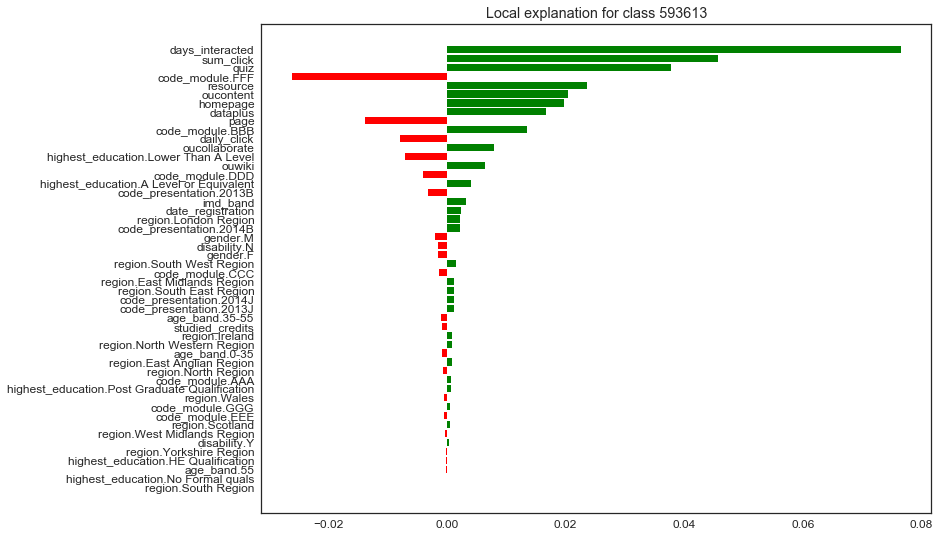

In [34]:
exp = exp.as_list(label=1)
fig = plt.figure()
vals = [x[1] for x in exp]
names = [x[0] for x in exp]
vals.reverse()
names.reverse()
colors = ['green' if x > 0 else 'red' for x in vals]
pos = np.arange(len(exp)) + .5
plt.barh(pos, vals, align='center', color=colors)
plt.yticks(pos, names)
title = 'Local explanation for class %s' % list(X_test.id)[exp_idx]
plt.title(title)

In [36]:
exp = explainer.explain_instance(test_X_imp_df.iloc[exp_idx,:].values, 
                                 estimator.predict_proba, num_features=num_features)
exp.show_in_notebook()

In [37]:
import shap

In [42]:
shap_explainer = shap.TreeExplainer(estimator)
# calculate the shapley values for our test set
test_shap_vals = shap_explainer.shap_values(test_X_imp)
print(test_shap_vals[0])
print(shap_explainer.expected_value[0])
print(test_X_imp_df.iloc[0,:])
print(y_test.head(1))

[[-3.46425795e-03  9.84646728e-03  2.28198731e-03 ...  3.42331736e-06
  -3.50834248e-04 -5.72450501e-05]
 [-4.14170656e-03  5.18097505e-05 -2.25589269e-04 ... -2.23363820e-05
  -3.72281847e-04 -2.99450827e-04]
 [-5.79901165e-03 -3.02268401e-02  9.97820112e-03 ... -2.35030320e-04
  -9.25572050e-04 -8.44397200e-04]
 ...
 [-2.26835415e-03  6.34916705e-03  2.56134685e-03 ... -3.39667008e-05
  -1.06329330e-03 -3.85720903e-04]
 [-3.61058610e-03  3.69841594e-04 -2.43538685e-03 ... -6.61624617e-05
  -7.08602659e-04 -5.05200551e-04]
 [ 1.13402927e-02  2.08152451e-02  1.95017114e-04 ...  8.20166389e-06
  -3.22794572e-04 -4.48434550e-04]]
0.40865627443417907
imd_band                                         0.234689
studied_credits                                  1.128508
date_registration                               -0.508784
dataplus                                        -0.241680
homepage                                        -0.644385
oucollaborate                                   -0.355

In [39]:
shap.initjs()

In [40]:
# shap.force_plot(test_X_imp_df.iloc[0, :], test_shap_vals[0, :])
shap.force_plot(shap_explainer.expected_value[0], test_shap_vals[0][0,:], test_X_imp_df.iloc[0,:])

In [41]:
shap.force_plot(shap_explainer.expected_value[0], train_shap_vals[0], train_X_imp_df)

NameError: name 'train_shap_vals' is not defined

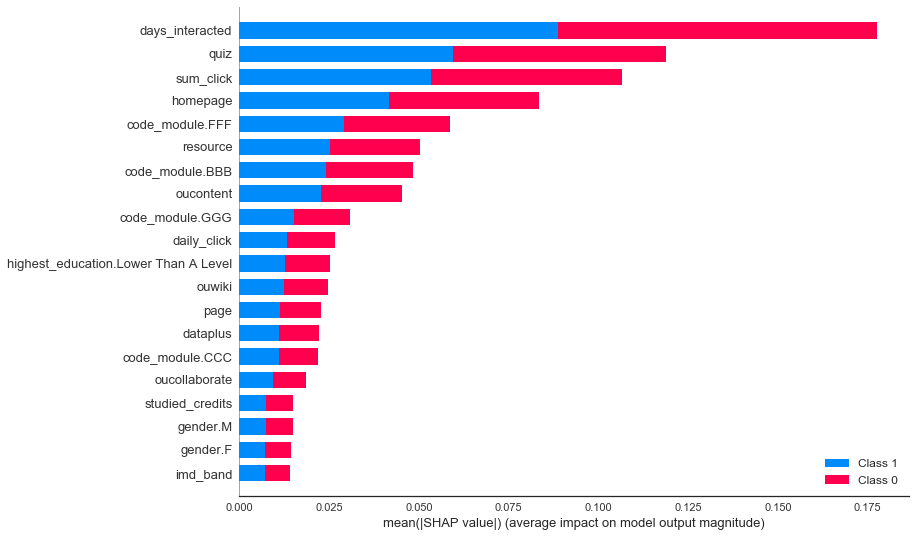

In [43]:
shap.summary_plot(test_shap_vals, test_X_imp_df, auto_size_plot=False)

In [47]:
train_expl_df.to_pickle('train_expl_df.pkl')
test_expl_df.to_pickle('test_expl_df.pkl')
feat_imp_df.to_pickle('feat_imp_df.pkl')
